###  Doing spectral analysis

The methods to compute the spectral analysis can be imported as follows:

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')

import time
import numpy                 as     np
import matplotlib.pyplot     as     plt
from   GDa.spectral_analysis import filtering, time_frequency
from   GDa.session           import session

Loading a session using the session class:

In [2]:
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
              slvr_msmod = False, align_to = 'cue', trial_type = 1, \
              behavioral_response = 1, evt_dt = [-0.65, 3.00], save_to_h5=False, h5_path=None) 

We can plot a random LFP signal:

In [3]:
lfp   = ses.data[0,10,:]
# Time axis, using from -0.65 to 3.00 s because this is the event dt we used when we saved the data
tarr  = ses.time

Text(0, 0.5, 'mV')

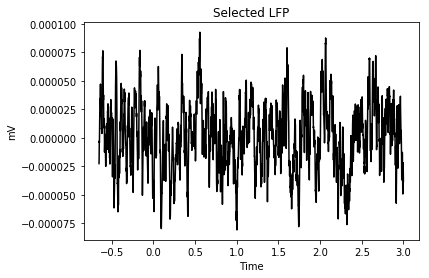

In [4]:
# Plotting the signal
plt.plot(tarr, lfp, 'k')
plt.title('Selected LFP')
plt.xlabel('Time')
plt.ylabel('mV')

We can bandpass filter the data with the function __bp_filter__ from __filtering__, let's filter it on the alpha band (8-15 Hz):

In [5]:
LFP_filtered = filtering.bp_filter(data = ses.data, fs = ses.readinfo['fsample'], 
                                   f_low = 8, f_high = 12, n_jobs = -1)

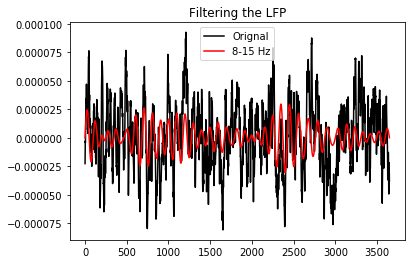

In [6]:
plt.plot(lfp, 'k')
plt.plot(LFP_filtered[0,10,:], 'r')
plt.title('Filtering the LFP')
plt.legend(['Orignal', '8-15 Hz'])

We can compute the wavelets of the signal using the function __wavelet_transform__, which allows to use morlet or multitaper transforms.

In [7]:
# Defining frequencies
freqs = np.arange(4,60,2)

# Morlet
W_ml = time_frequency.wavelet_transform(data = ses.data,  
                                        fs = ses.readinfo['fsample'], freqs = freqs, n_cycles = 5,
                                        time_bandwidth = None, delta = 15, method = 'morlet', n_jobs = -1)

# Multitaper
#W_mt = spec.wavelet_transform(data = LFP,  
#                              fs = fsample, freqs = freqs, n_cycles = freqs/2.0,
#                              time_bandwidth = 8.0, delta = 15, method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   12.9s remaining:   18.7s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   13.8s remaining:    8.7s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   14.7s remaining:    3.3s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   17.7s finished


The auto spectra can be computed as tem elementwise product of $W$ and its conjugate:

In [8]:
Sauto_ml = W_ml * np.conj(W_ml)

Next, we can visualize the result for __trial=0__, and __channel=10__:

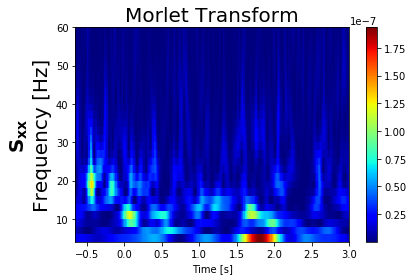

In [9]:
plt.imshow(Sauto_ml[0,10,:,:].real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,4,60]);plt.colorbar()
plt.title('Morlet Transform', fontsize=20)
plt.ylabel(r"$\bf{S_{xx}}$" + "\n" + "Frequency [Hz]", fontsize=20)
plt.xlabel('Time [s]')
plt.tight_layout()

Finally we can compute the (single trial) time-frequency coherence between two signals by using the function __wavelet_coherence__, for each trial and pair a file will be saved in __dir_out__ with the coherence data.

An array with the pairs of channels (pairs = $[[0,1], [0,2], \dots, [n,n]]$) should be passed to the function (note that you don't necessarily have to provide every pair possible, you can also focus on a few pairs you are interested).

If $n_{\rm jobs}>1$, it will parallelize on pairs of channels, to test let's compute it passing only one trial of the data, and measure the execution time:

In [10]:
start = time.time()

time_frequency.wavelet_coherence(data = ses.data[:10,:,:], pairs = ses.readinfo['pairs'], fs = ses.readinfo['fsample'], 
                                 freqs = freqs, n_cycles = 5, time_bandwidth = None, delta = 15, method = 'morlet', 
                                 win_time = 34, win_freq = 1, dir_out = 'data', n_jobs = -1)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    0.5s finished


Elapsed time to load super-tensor: 8.748176574707031 sec.


We can load a saved file with the coherence in order to plot:

In [11]:
import h5py
with h5py.File('data/ch1_10_ch2_30.h5', 'r') as hf:
    coh = np.array(hf.get('coherence'))

Text(0.5, 0, 'Time [s]')

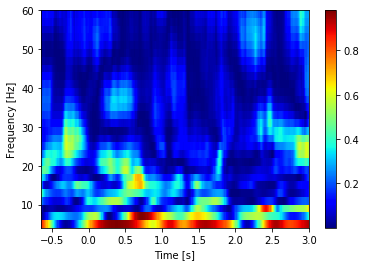

In [12]:
plt.imshow(coh[0,:,:], aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3,4,60]); plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

The spectral analysis class also have the __gabor_coherence__ method which allows computing the coherence between a pair os signals, since it is not built uppon MNE the parameters we should pass are not the whole data but two single LFP signals, let's call this funtion for the same signals we have plot above (__trial=0__, __channel1=10__, and __channel2=30__).

In [13]:
signal1 = ses.data[0,10,:]
signal2 = ses.data[0,30,:]

coh_gabor = time_frequency.gabor_coherence(signal1 = signal1, signal2 = signal2, fs = ses.readinfo['fsample'], 
                                           freqs = freqs, win_time = 500, win_freq = 3, n_cycles = 5)

Text(0.5, 0, 'Time [s]')

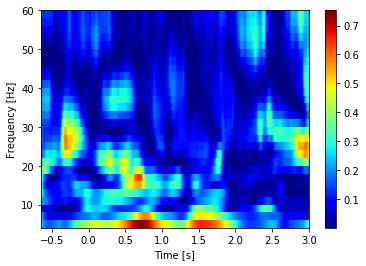

In [14]:
plt.imshow(coh_gabor.real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3,4,60]); plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

As it can be seen the results as pretty similar, as expected.